# MSDS Thesis
## Data Analysis in Python for olfactoneuroimaging data

Apoorv Saraogee MSDS 599 - Dr. Srinivasan

In [14]:
import pandas as pd
import numpy as np

import visualkeras
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, Flatten, GlobalAveragePooling3D, Lambda, Dense, TimeDistributed, LSTM, Permute, Reshape, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report
from keras.regularizers import l2

## Setup of model and variables

In [3]:
# Load the filtered DataFrame from the pickle file
input_pickle_file = 'filtered_events.pkl'
filtered_combined_df = pd.read_pickle(input_pickle_file)

# Print the DataFrame to verify its contents
print(f"Loaded DataFrame from {input_pickle_file}:")
print(filtered_combined_df.head())


Loaded DataFrame from filtered_events.pkl:
  subject run_modality  onset  dicom_start  dicom_end   smell response_type   
0  sub-13       run-02    4.2            3         19  orange      positive  \
1  sub-13       run-02  153.0          102        118  orange      positive   
2  sub-13       run-02  269.7          180        196  orange      positive   
3  sub-13       run-02  383.7          256        272  orange      positive   
4  sub-13       run-02  507.5          338        354  orange      positive   

                       idno                                               data  
0    sub-13_run-02_3_orange  [[[[ 0. -0.  0.  0. -0.  0.  0.  0.  0.  0. -0...  
1  sub-13_run-02_102_orange  [[[[ 0.  0. -0. -0. -0.  0. -0. -0.  0.  0. -0...  
2  sub-13_run-02_180_orange  [[[[ 0.  0. -0. -0. -0.  0.  0. -0.  0. -0.  0...  
3  sub-13_run-02_256_orange  [[[[ 0. -0. -0.  0.  0. -0. -0.  0. -0. -0. -0...  
4  sub-13_run-02_338_orange  [[[[ 0. -0. -0. -0.  0. -0. -0.  0.  0.  0. -0..

In [4]:
# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Fit and transform the 'response_type' column
filtered_combined_df['label'] = label_encoder.fit_transform(filtered_combined_df['response_type'])

# Verify the transformation
print(filtered_combined_df[['response_type', 'label']].head())

# Extract data and labels
X = np.stack(filtered_combined_df['data'].values)  # Stack the arrays to create a 5D array
y = filtered_combined_df['label'].values  # Numeric labels

print(f"Data shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print("Type of data array:", type(X))
print("Data array dtype:", X.dtype)

  response_type  label
0      positive      1
1      positive      1
2      positive      1
3      positive      1
4      positive      1
Data shape: (806, 110, 104, 27, 16)
Labels shape: (806,)
Type of data array: <class 'numpy.ndarray'>
Data array dtype: float32


In [15]:
model = Sequential([
    # Permute dimensions to have time as the first dimension for TimeDistributed
    Permute((4, 1, 2, 3), input_shape=(110, 104, 27, 16)),  # Shape becomes (16, 110, 104, 27)
    
    # Add a channel dimension (e.g., 1 channel)
    Lambda(lambda x: tf.expand_dims(x, -1)),  # Adds a channel dimension, shape becomes (16, 110, 104, 27, 1)
    
    # Apply Conv3D to each time slice independently using TimeDistributed
    TimeDistributed(Conv3D(32, (5, 5, 5), activation='relu', padding='same', kernel_regularizer=l2(0.001))),
    TimeDistributed(MaxPooling3D(pool_size=(2, 2, 2), strides=2)),
    
    TimeDistributed(Conv3D(48, (5, 5, 5), activation='relu', padding='valid', kernel_regularizer=l2(0.001))),
    TimeDistributed(MaxPooling3D(pool_size=(2, 2, 2), strides=2)),
    
    # Apply global average pooling to reduce spatial dimensions before LSTM
    TimeDistributed(GlobalAveragePooling3D()),  # Removes channel dependency, reduces spatial dimensions
    
    # Apply LSTM to handle the temporal dimension
    LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001)),
    
    # Final Dense layers for classification
    Dense(24, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # Binary classification
              metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute_7 (Permute)         (None, 16, 110, 104, 27)  0         
                                                                 
 lambda_3 (Lambda)           (None, 16, 110, 104, 27,  0         
                              1)                                 
                                                                 
 time_distributed_28 (TimeDi  (None, 16, 110, 104, 27,  4032     
 stributed)                   32)                                
                                                                 
 time_distributed_29 (TimeDi  (None, 16, 55, 52, 13, 3  0        
 stributed)                  2)                                  
                                                                 
 time_distributed_30 (TimeDi  (None, 16, 51, 48, 9, 48  192048   
 stributed)                  )                        

2024-09-18 03:24:50.168019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-09-18 03:24:50.170798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-09-18 03:24:50.173309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

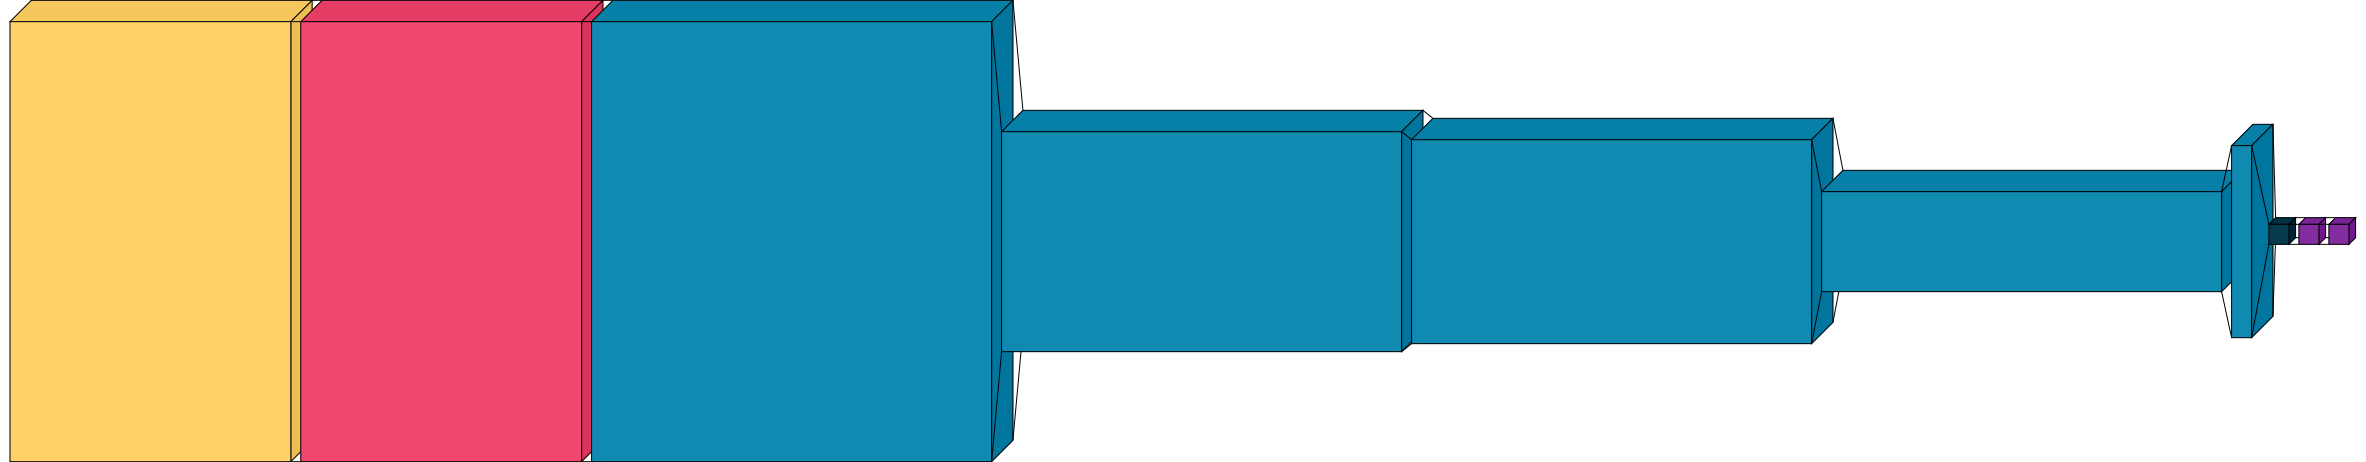

In [16]:
visualkeras.layered_view(model)

## Modeling

In [17]:
# Assume X and y are your full dataset and labels
# Example data shapes:
# X.shape = (806, 110, 104, 27, 16)
# y.shape = (806, )

# Split the data into training and holdout sets
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Callbacks for learning rate scheduling and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train the model with callbacks
history = model.fit(
    X_train, y_train,
    epochs=20,  # Increased epochs for better convergence
    batch_size=8,  # Increased batch size for stable gradients
    validation_split=0.2,
    callbacks=[reduce_lr, early_stop]
)


Epoch 1/20


2024-09-18 03:29:21.077860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-09-18 03:29:21.083167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-09-18 03:29:21.087883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

: 

: 

In [ ]:
# Evaluate the model on the holdout set
loss, accuracy = model.evaluate(X_holdout, y_holdout)
print(f"Holdout set loss: {loss:.4f}")
print(f"Holdout set accuracy: {accuracy:.4f}")

# Predict on the holdout set
y_pred = model.predict(X_holdout)

# Convert predictions to binary labels (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Print the first few predictions and corresponding true labels
print("Predictions on holdout set (first 5):", y_pred_binary[:5].flatten())
print("True labels on holdout set (first 5):", y_holdout[:5])

# Classification report for additional metrics
print(classification_report(y_holdout, y_pred_binary))
